### <strong><font color=cornflowerblue>第三次作品：比較多元羅吉斯迴歸、SVM 與神經網路在原始與 PCA 人臉資料上的分類表現（前篇）</font></strong>
學號：411078064

姓名：謝意盛
<hr>

### <strong>作品目標</strong>：

本實驗旨在比較 **多元羅吉斯迴歸（MLR）**、**支援向量機（SVM）** 與 **多層感知器神經網路（MLP）** 三種分類模型，在處理人臉影像資料時的表現差異。資料來源包括 **來自 AT&T 40 個人的人臉影像** 與 **來自 Yale Face 38 人的人臉影像**，並同時針對**原始影像資料**與**經主成分分析（PCA）降維後的資料**進行訓練與測試。實驗聚焦於探討不同模型在準確率、收斂速度與泛化能力等層面的表現，並進一步分析 PCA 是否有助於提升模型效能與訓練效率，最終目標為找出最適合應用於 AT&T 影像資料的分類模型與資料處理方式。
本篇為前篇，主要針對 AT&T 影像資料進行分析與討論。


<hr>

#### <strong>參考資料</font>：

1. [汪群超 Chun-Chao Wang 老師講義](https://ntpuccw.blog/python-in-learning/sml%e6%b7%ba%e5%ba%a6%e6%a9%9f%e5%99%a8%e5%ad%b8%e7%bf%92%ef%bc%9apca-%e3%80%81svd-%e5%8f%8a%e5%85%b6%e5%9c%a8%e5%bd%b1%e5%83%8f%e8%99%95%e7%90%86%e7%9a%84%e6%87%89%e7%94%a8/)

<hr>

#### <strong>載入套件</strong>：

In [1]:
import os, time, socket, datetime
from platform import python_version
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib  # 儲存模型

# 分類器
## Logistic Regression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
## SVM
from sklearn.svm import SVC, LinearSVC
# Neutral Network
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay

## MyLib
import MyLib  # 自己寫的函式庫
from importlib import reload
reload(MyLib) # 重新載入MyLib，這樣才會更新
from MyLib import show_Yale, show_AT, format_runtime
from MyLib import show_AT

# print("【日期時間】{}".format(time.strftime("%Y/%m/%d %H:%M:%S")))
# print("【工作目錄】{}".format(os.getcwd()))
# print("【主機名稱】{} ({})".format(socket.gethostname(),socket.gethostbyname(socket.gethostname())))
# print("【Python】{}".format(python_version()))
# print("【虛擬環境】{}".format(os.environ.get('VIRTUAL_ENV')))  # 查看使用的虛擬環境


<hr>
<hr>

### **<font color=cornflowerblue>第 1 題：</font>**  

本實驗將採用三種分類器，針對 AT&T 40 位受試者的人臉影像資料（共 400 張，每張大小為 64 × 64）進行分類學習與測試。資料分為「原始資料」與「主成分資料」兩種形式，並分別進行訓練與評估，以比較不同資料型態下各分類器的表現差異。

所使用的三種分類器如下：

1. 多元羅吉斯回歸 (Multinomial Logistic Regression)

1. 支援向量機 (Support Vector Machine)

1. 神經網路 (Neural Network)

#### **1.1 匯入 AT&T 40 位受試者的人臉影像資料，觀察資料的基本屬性。**

【影像矩陣形狀】：
 (n, pixels) = (400, 4096)
【總人數】：40
【資料 Labels】：
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
【圖片大小】： 64 x 64

【前 10 張圖片】：


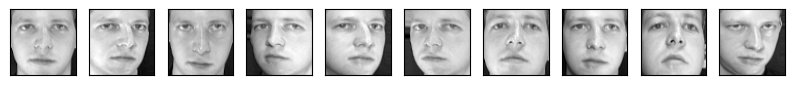

In [2]:
df_file = r'D:\ys\B4_ShallowML\ShallowML\ClassData'
df_path = os.path.join(df_file, 'face_data.csv')
df_AT = pd.read_csv(df_path)
X_AT = np.array(df_AT.drop(columns=['target']))
y_AT = np.array(df_AT['target'])

# 資料屬性
print(f"【影像矩陣形狀】：\n (n, pixels) = {X_AT.shape}")
# pd.Series(y_AT).nunique()
print(f"【總人數】：{df_AT['target'].nunique()}")
print(f"【資料 Labels】：\n {np.unique(y_AT)}")

# 顯示圖片
px = np.sqrt(X_AT.shape[1]).astype(int)
m, n = px, px
print(f"【圖片大小】： {m} x {n}")
print("\n【前 10 張圖片】：")
show_AT(X_AT[:10, :].T, m, n, 1, 10)

#### **1.2 劃分 70% 的資料作為訓練資料，其他 30% 作為測試資料。**

In [3]:
# 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_AT, y_AT, test_size=0.30, random_state=2025)

# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train) # 標準化訓練資料
X_test_ = scaler.fit_transform(X_test) # 標準化測試資料

# print the numbers of training and testing samples
print(f"【訓練資料】： {X_train_.shape[0]}")
print(f"【測試資料】： {X_test_.shape[0]}")
print(f"【訓練資料 Labels 數量最小值】： {pd.Series(y_train).value_counts().min()}")
# print the shape of the data
print(f"【訓練資料 shape】： {X_train_.shape}")
print(f"【測試資料 shape】： {X_test_.shape}")

【訓練資料】： 280
【測試資料】： 120
【訓練資料 Labels 數量最小值】： 4
【訓練資料 shape】： (280, 4096)
【測試資料 shape】： (120, 4096)


#### **1.3 對資料進行 PCA，並擷取累積解釋變異量達 90% 所對應的主成分作為新資料。**

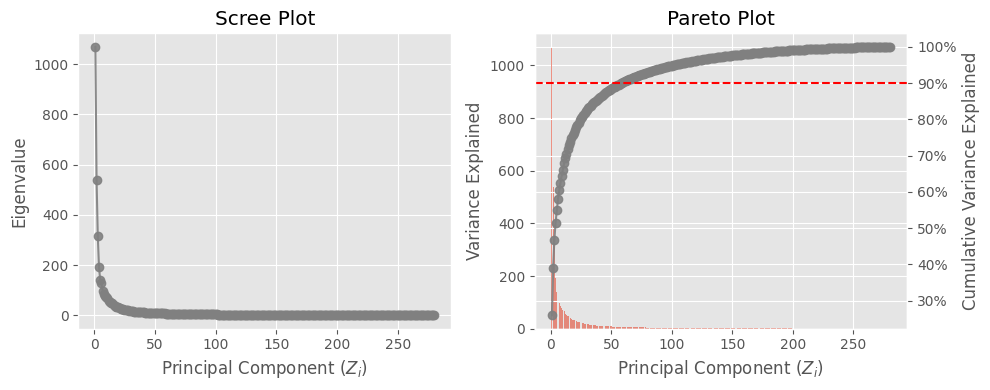

In [4]:
# train
pca = PCA()
Z_train = pca.fit_transform(X_train_)
Z_test = pca.transform(X_test_)
eigenvalues = pca.explained_variance_

# 繪製 scree plot 和 pareto plot
# 計算主成分數量
pca_range = np.arange(1, len(eigenvalues) + 1)
# 計算解釋變異量
cum_var_exp = np.cumsum(eigenvalues / eigenvalues.sum()) * 100

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Scree Plot
ax[0].plot(pca_range, eigenvalues, 'o-', alpha=0.9, color='gray')
ax[0].set_title('Scree Plot')
ax[0].set_xlabel('Principal Component ($Z_i$)')
ax[0].set_ylabel('Eigenvalue')

# Pareto Plot
ax2 = ax[1].twinx()  # 創建共享 x 軸的第二個 y 軸
ax[1].bar(pca_range, eigenvalues, alpha=0.6, align='center', label='Individual explained variance')
ax[1].set_title('Pareto Plot')
ax[1].set_xlabel('Principal Component ($Z_i$)')
ax[1].set_ylabel('Variance Explained')
# ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0e}'.format(x)))
# 畫出累積解釋變異量，用百分比表示
ax2.plot(pca_range, cum_var_exp, 'o-', alpha=0.9, color='gray')
ax2.axhline(90, color='red', linestyle='--', label='90% Variance')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

plt.tight_layout()
plt.show()


In [5]:
# 取出解釋變異量大於 0.9 的主成分數量
n_components = np.argmax(cum_var_exp >= 90) + 1
print(f"【主成分數量】： {n_components}")

Z_train_ = Z_train[:, :n_components]
Z_test_ = Z_test[:, :n_components]
print(f"【PCA 後訓練資料 shape】： {Z_train_.shape}")
print(f"【PCA 後測試資料 shape】： {Z_test_.shape}")


【主成分數量】： 59
【PCA 後訓練資料 shape】： (280, 59)
【PCA 後測試資料 shape】： (120, 59)


<hr>

#### **1.4 使用多元羅吉斯回歸 (Multinomial Logistic Regression) 對「原始資料」與「主成分資料」進行訓練與評估，比較不同資料型態下分類器的表現差異。**

##### **1. 原始資料**

**超參數設定：**
- `solver`: 'lbfgs', 'liblinear'

- `C`: np.linspace(1.5, 2, 5)

- `penalty`: 'l2'

- `cv`: 4

In [21]:
opts = dict(tol = 1e-6, max_iter = int(1e6))
# params = {
#     'solver': ['lbfgs', 'liblinear'],
#     'C': np.linspace(1.5, 2, 5),
#     'penalty': ['l2']
#} # parameters for GridSearchCV
params = {
    'solver': ['lbfgs'],
    'C': [1.875],
    'penalty': ['l2']
}

# --- Logistic Regression with GridSearch ---
# 記錄執行時間
start = time.time()
grid_LR = GridSearchCV(estimator=LogisticRegression(**opts),
                        param_grid=params,
                        cv=4,
                        scoring=['accuracy', 'f1_macro'],
                        refit='accuracy',
                        n_jobs=-1)
grid_LR.fit(X_train_, y_train)
runtime_LR = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_LR, "Model/AT_MLR_model.pkl");


===== MLR with GridSearchCV =====

【執行時間】： 00:00:22

【Best Params】：
{'C': 1.875, 'penalty': 'l2', 'solver': 'lbfgs'}

【模型結果】：
Training score = 100.00%
Testing score = 98.33%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         1
          14  

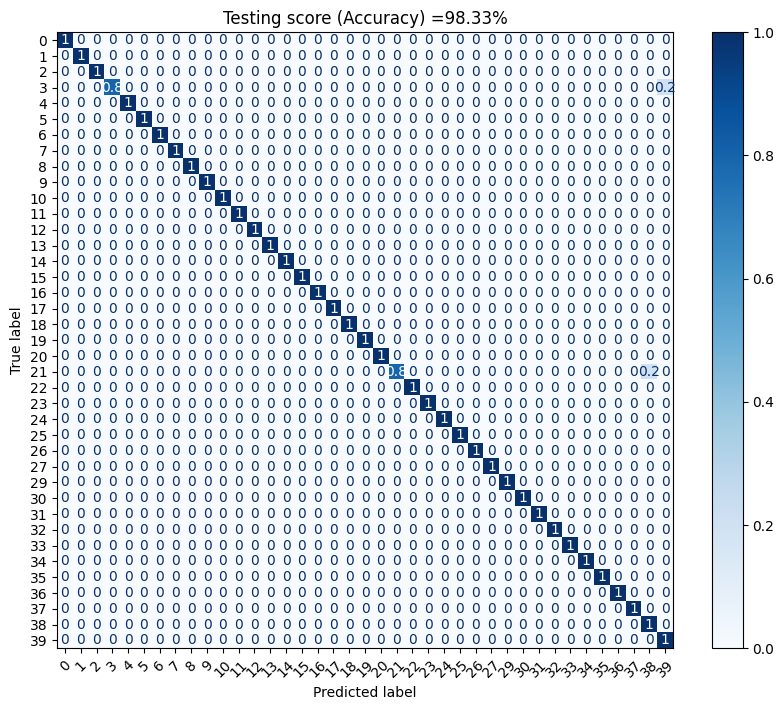

In [22]:
# 使用模型預測
y_pred = grid_LR.predict(X_test_)

# --- Results Report ---
print("===== MLR with GridSearchCV =====\n")
print(f"【執行時間】： {format_runtime(runtime_LR)}\n")
print(f"【Best Params】：\n{grid_LR.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_LR.predict(X_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_LR.score(X_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (Accuracy) ={:.2f}%'.format(100*grid_LR.score(X_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_LR,
        X_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()


##### **2. 主成分資料**

**超參數設定：**
- `solver`: 'lbfgs', 'liblinear'

- `C`: np.linspace(0.01, 1, 20)

- `penalty`: 'l2'

- `cv`: 4

In [23]:
opts = dict(tol = 1e-6, max_iter = int(1e6))
# params = {
#     'solver': ['lbfgs', 'liblinear'],
#     'C': np.linspace(1.5, 2, 5),
#     'penalty': ['l2']
#} # parameters for GridSearchCV
params = {'solver': ['lbfgs'],
          'C': [0.37473684210526315],
          'penalty': ['l2']}

# --- Logistic Regression with GridSearch ---
# 記錄執行時間
start = time.time()
grid_pca_LR = GridSearchCV(estimator=LogisticRegression(**opts),
                        param_grid=params,
                        cv=4,
                        scoring=['accuracy', 'f1_macro'],
                        refit='accuracy',
                        n_jobs=-1)
grid_pca_LR.fit(Z_train_, y_train)
runtime_pca_LR = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_LR, "Model/AT_MLR_PCA_model.pkl");


===== MLR with GridSearchCV (PCA) =====

【執行時間】： 00:00:01

【Best Params】：
{'C': 0.37473684210526315, 'penalty': 'l2', 'solver': 'lbfgs'}

【模型結果】：
Training score = 100.00%
Testing score = 98.33%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00     

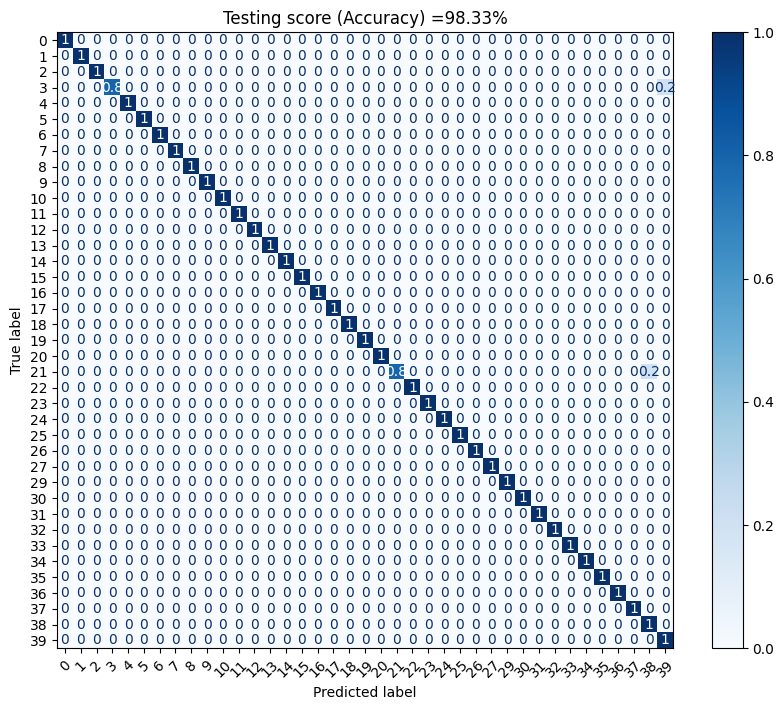

In [24]:
# 使用模型預測
y_pred = grid_pca_LR.predict(Z_test_)

# --- Results Report ---
print("===== MLR with GridSearchCV (PCA) =====\n")
print(f"【執行時間】： {format_runtime(runtime_pca_LR)}\n")
print(f"【Best Params】：\n{grid_pca_LR.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_pca_LR.predict(Z_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_pca_LR.score(Z_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (Accuracy) ={:.2f}%'.format(100*grid_pca_LR.score(Z_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_pca_LR,
        Z_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()


##### **注意事項與討論：**  

- 上述實驗分別使用多元羅吉斯回歸（MLR）對『原始資料』與『主成分資料（PCA 資料）』進行模型訓練，結果顯示兩種資料形態下所訓練出的模型，其 Testing Score 均為 98.33%，整體分類表現極佳。

- 從混淆矩陣與分類報告中可進一步觀察，兩種模型在大多數類別的 precision、recall 與 f1-score 皆為 1.00，僅在某些 support 數較少的類別（如類別 3）略有差異，但整體影響不大。

- 值得注意的是，儘管 PCA 模型的輸入維度已大幅降低（僅保留可解釋 90% 變異量的主成分），其分類效能仍與原始高維資料相當，代表透過 PCA 可以在減少特徵數量的同時保有良好表現，對於模型效能提升、避免過擬合與訓練效率提升皆有助益。

- 整體而言，本實驗結果顯示 PCA 並未對 MLR 模型的分類效能造成負面影響，反而有助於簡化模型結構、提升運算效率，進一步節省訓練時間。同時，多元羅吉斯回歸在本資料集下展現出穩定且可靠的表現，證實此方法對 AT&T 40 位受試者的人臉影像具有良好的分類效果。

<hr>

#### **1.5 使用支援向量機 (Support Vector Machine) 對「原始資料」與「主成分資料」進行訓練與評估，比較不同資料型態下分類器的表現差異。**

##### **1. 原始資料**

**超參數設定：**
- `C`: np.linspace(1e-6, 0.01, 5)

- `kernel`: 'linear', 'rbf'

- `gamma`: 'scale', 'auto'

- `cv`: 4

In [25]:
opts = dict(tol = 1e-6, max_iter = int(1e6))
# params = {
#     'C': np.linspace(1e-6, 0.01, 5),
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }
params = {
    'C': [0.0025007500000000004],
    'kernel': ['linear'],
    'gamma': ['scale']
}

# --- SVM ---
# 記錄執行時間
start = time.time()
grid_SVM = GridSearchCV(estimator=SVC(**opts),
                        param_grid=params,
                        cv=4,
                        scoring=['accuracy', 'f1_macro'],
                        refit='f1_macro',
                        n_jobs=-1)
grid_SVM.fit(X_train_, y_train)
runtime_SVM = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_SVM, "Model/AT_SVM_model.pkl");


===== SVM with GridSearchCV =====

【執行時間】： 00:00:00

【Best Params】：
{'C': 0.0025007500000000004, 'gamma': 'scale', 'kernel': 'linear'}

【模型結果】：
Training score = 100.00%
Testing score = 96.41%

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       0.80      1.00      0.89         4
          13       1.00      1.00      1.00       

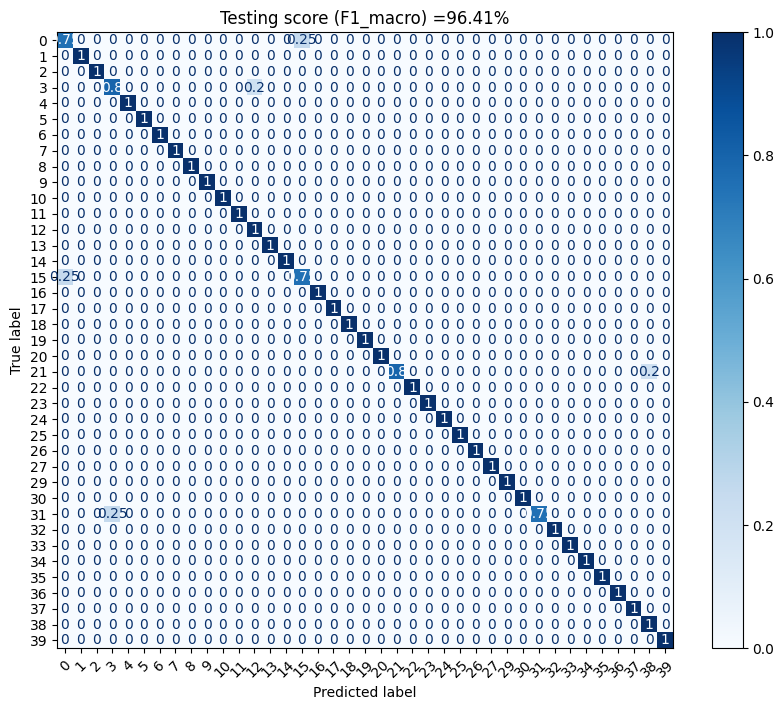

In [26]:
# 使用模型預測
y_pred = grid_SVM.predict(X_test_)

# --- Results Report ---
print("===== SVM with GridSearchCV =====\n")
print(f"【執行時間】： {format_runtime(runtime_SVM)}\n")
print(f"【Best Params】：\n{grid_SVM.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_SVM.predict(X_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_SVM.score(X_test_, y_test):.2%}\n")
# print(grid_SVM.best_score_)
# print(grid_SVM.best_estimator_)
# 分類報告
print(classification_report(y_test, y_pred))

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (F1_macro) ={:.2f}%'.format(100*grid_SVM.score(X_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_SVM,
        X_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()


##### **2. 主成分資料**

**超參數設定：**
- `C`: np.linspace(1e-6, 0.01, 5)

- `kernel`: 'linear', 'rbf'

- `gamma`: 'scale', 'auto'

- `cv`: 4

In [27]:
opts = dict(tol = 1e-6, max_iter = int(1e6))
# params = {
#     'C': np.linspace(1e-6, 0.01, 5),
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }
params = {
    'C': [0.0025007500000000004],
    'kernel': ['linear'],
    'gamma': ['scale']
}

# --- SVM ---
# 記錄執行時間
start = time.time()
grid_pca_SVM = GridSearchCV(estimator=SVC(**opts),
                        param_grid=params,
                        cv=4,
                        scoring=['accuracy', 'f1_macro'],
                        refit='f1_macro',
                        n_jobs=-1)
grid_pca_SVM.fit(Z_train_, y_train)
runtime_pca_SVM = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_SVM, "Model/AT_SVM_PCA_model.pkl");


===== SVM with GridSearchCV (PCA) =====

【執行時間】： 00:00:00

【Best Params】：
{'C': 0.0025007500000000004, 'gamma': 'scale', 'kernel': 'linear'}

【模型結果】：
Training score = 100.00%
Testing score = 96.96%

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00 

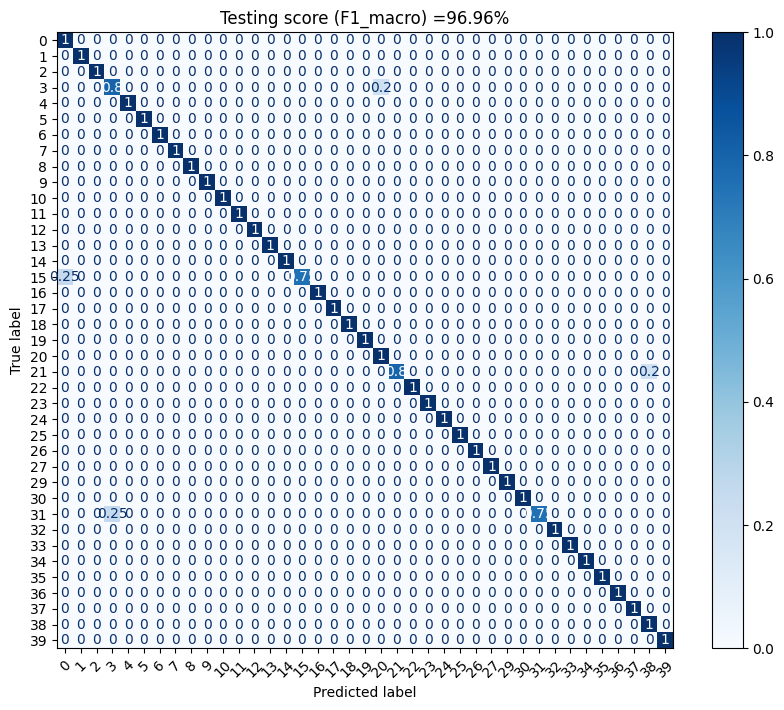

In [29]:
# 使用模型預測
y_pred = grid_pca_SVM.predict(Z_test_)

# --- Results Report ---
print("===== SVM with GridSearchCV (PCA) =====\n")
print(f"【執行時間】： {format_runtime(runtime_pca_SVM)}\n")
print(f"【Best Params】：\n{grid_pca_SVM.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_pca_SVM.predict(Z_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_pca_SVM.score(Z_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (F1_macro) ={:.2f}%'.format(100*grid_pca_SVM.score(Z_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_pca_SVM,
        Z_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()


##### **注意事項與討論：**  

- 本實驗使用 Support Vector Machine（SVM）模型，分別對『原始資料』與經 PCA 降維後的『主成分資料』進行分類訓練。由結果可見，原始資料的 Testing Score 為 96.41%，而主成分資料略高，達 96.96%。顯示在本資料集下，PCA 有助於提升模型的泛化能力。

- 雖然兩組結果非常接近，但可以觀察到，主成分資料在 recall 與 macro average 的表現上更為穩定，顯示降維後的資料在保留關鍵特徵的同時，有效減少了雜訊對模型訓練的干擾。

- 相較於前述的多元羅吉斯回歸（MLR）模型，其在原始與主成分資料上皆能達到 98.33% 的測試正確率，顯示其在處理此 AT&T 臉部辨識任務時具有穩定性與高度準確率。而 SVM 雖略低一些，但整體而言，其在處理高維度影像資料方面仍展現良好的表現，且對 PCA 特別敏感，透過降維有機會進一步提升分類準確性。

- 綜合而言，SVM 透過 PCA 可有效提升泛化能力，雖仍不及 MLR 的穩定高效，但在精度與計算效率上提供了不同的應用價值，亦驗證了降維對於某些模型的助益。這樣的觀察有助於日後針對不同資料型態選擇合適的預處理策略與分類方法。

<hr>

#### **1.6 使用神經網路 (Neural Network) 對「原始資料」與「主成分資料」進行訓練與評估，比較不同資料型態下分類器的表現差異。**

##### **1. 原始資料**

**超參數設定：**
- `hidden_layer_sizes`: (32,), (64,)

- `activation`: 'relu', 'logistic'

- `solver`: 'adam'

- `alpha`: 0.001

In [30]:
opts = dict(verbose = False, tol = 1e-6, max_iter = int(1e6), random_state=2025)
# params = {
#     'hidden_layer_sizes': [(32,), (64,)],
#     'activation': ['relu', 'logistic'],
#     'solver': ['adam'],
#     'alpha': [0.001],
# }
params = {
    'hidden_layer_sizes': [(64,)],
    'activation': ['logistic'],
    'solver': ['adam'],
    'alpha': [0.001],
}

# --- Neural Network ---
# 記錄執行時間
start = time.time()
grid_MLP = GridSearchCV(estimator=MLPClassifier(**opts),
                        param_grid=params,
                        cv=4,
                        scoring=['accuracy', 'f1_macro'],
                        refit='f1_macro',
                        n_jobs=-1)
grid_MLP.fit(X_train_, y_train)
runtime_MLP = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_MLP, "Model/AT_NN_model.pkl");


===== NN with GridSearchCV =====

【執行時間】： 00:03:25

【Best Params】：
{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (64,), 'solver': 'adam'}

【模型結果】：
Training score = 100.00%
Testing score = 96.45%

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         2
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         6
           6       1.00      0.75      0.86         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         4
          13       1.00     

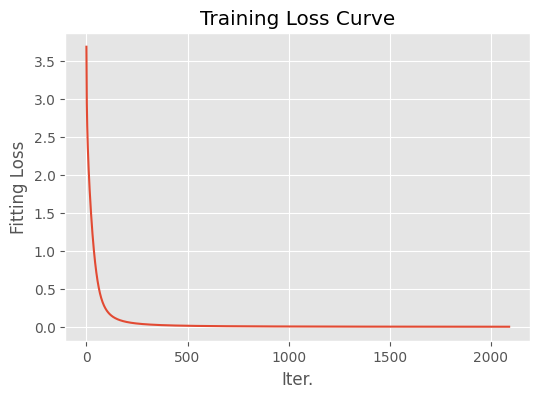

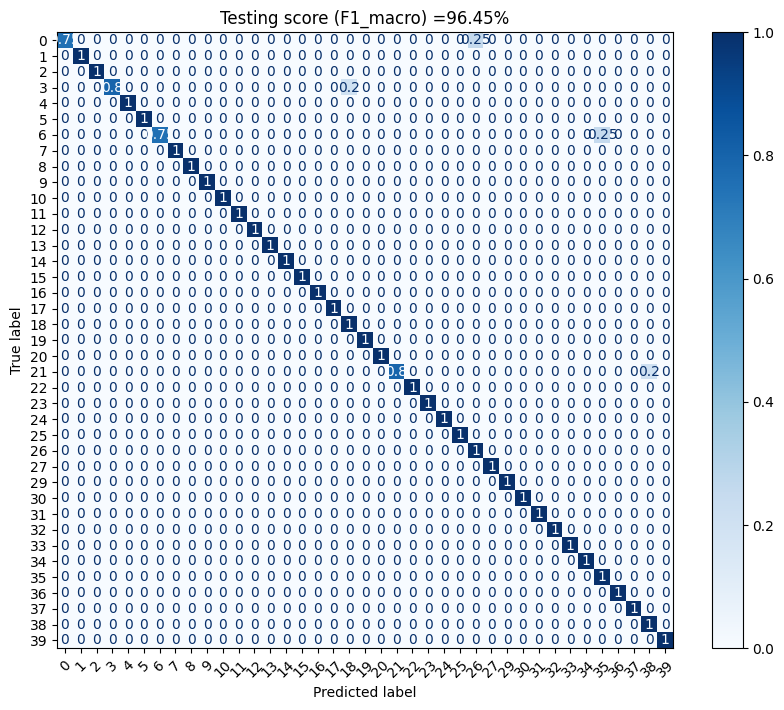

In [36]:
# 使用模型預測
y_pred = grid_MLP.predict(X_test_)

# --- Results Report ---
print("===== NN with GridSearchCV =====\n")
print(f"【執行時間】： {format_runtime(runtime_MLP)}\n")
print(f"【Best Params】：\n{grid_MLP.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_MLP.predict(X_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_MLP.score(X_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.plot(grid_MLP.best_estimator_.loss_curve_, '-')
plt.grid(True)
plt.title('Training Loss Curve')
plt.xlabel('Iter.')
plt.ylabel('Fitting Loss')
plt.show()

# Confusion matrix
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (F1_macro) ={:.2f}%'.format(100*grid_MLP.score(X_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_MLP,
        X_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show() 

##### **2. 主成分資料**

**超參數設定：**
- `hidden_layer_sizes`: (32,), (64,), (128,)

- `activation`: 'relu', 'logistic'

- `solver`: 'adam'

- `alpha`: 0.001, 0.01

In [32]:
opts = dict(verbose = False, tol = 1e-6, max_iter = int(1e6), random_state=2025)
# params = {
#     'hidden_layer_sizes': [(32,), (64,), (128,)],
#     'activation': ['relu', 'logistic'],
#     'solver': ['adam'],
#     'alpha': [0.001, 0.01],
# }
params = {
    'hidden_layer_sizes': [(64,)],
    'activation': ['logistic'],
    'solver': ['adam'],
    'alpha': [0.01],
}

# --- Neural Network ---
# 記錄執行時間
start = time.time()
grid_pca_MLP = GridSearchCV(estimator=MLPClassifier(**opts),
                        param_grid=params,
                        cv=4,
                        scoring=['accuracy', 'f1_macro'],
                        refit='f1_macro',
                        n_jobs=-1)
grid_pca_MLP.fit(Z_train_, y_train)
runtime_pca_MLP = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_MLP, "Model/AT_NN_PCA_model.pkl");


===== NN with GridSearchCV (PCA) =====

【執行時間】： 00:00:08

【Best Params】：
{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (64,), 'solver': 'adam'}

【模型結果】：
Training score = 100.00%
Testing score = 91.64%

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         4
           2       0.67      1.00      0.80         2
           3       1.00      0.40      0.57         5
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         4
          13       1.00

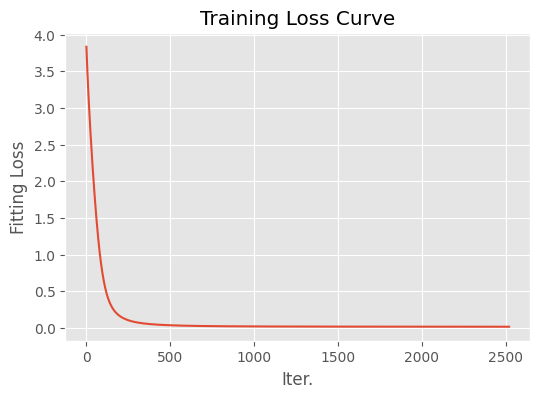

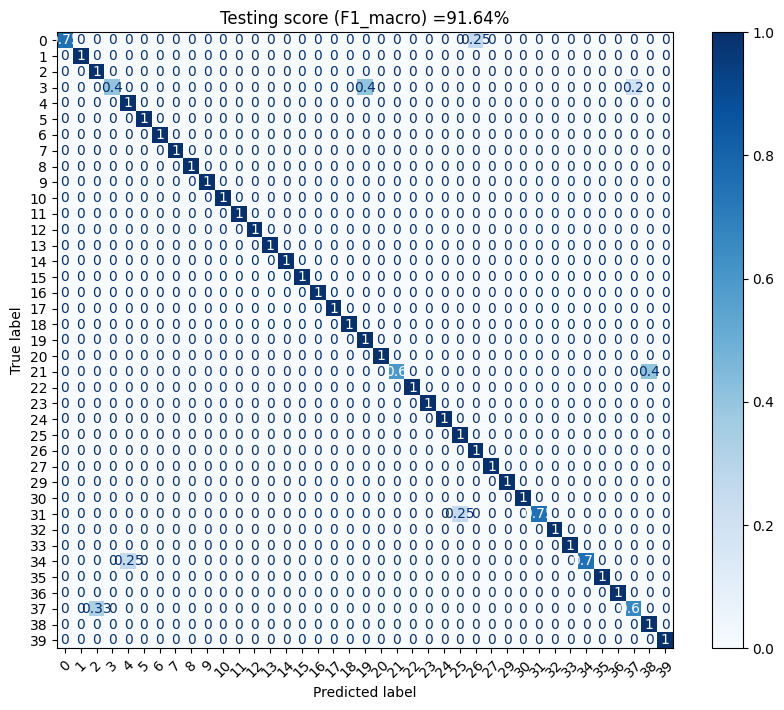

In [37]:
# 使用模型預測
y_pred = grid_pca_MLP.predict(Z_test_)

# --- Results Report ---
print("===== NN with GridSearchCV (PCA) =====\n")
print(f"【執行時間】： {format_runtime(runtime_pca_MLP)}\n")
print(f"【Best Params】：\n{grid_pca_MLP.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_pca_MLP.predict(Z_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_pca_MLP.score(Z_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.plot(grid_pca_MLP.best_estimator_.loss_curve_)
plt.grid(True)
plt.title('Training Loss Curve')
plt.xlabel('Iter.')
plt.ylabel('Fitting Loss')
plt.show()

# Confusion matrix
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (F1_macro) ={:.2f}%'.format(100*grid_pca_MLP.score(Z_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_pca_MLP,
        Z_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()


##### **注意事項與討論：**  

- 本實驗中，使用 MLP 神經網路對『原始資料』與『主成分資料』進行訓練與測試，發現原始資料的 Testing Score 達到 96.45%，而 PCA 後的資料下降至 91.64%，表現明顯不如原始資料。

- 儘管兩者在訓練集上皆達到 100% 的準確率，但在測試集上的落差，顯示 PCA 可能導致部分辨識特徵流失，對 MLP 模型較為敏感，特別是在資料維度壓縮下，容易影響到神經網路捕捉特徵的能力。

- 搭配前面觀察，MLR 模型對 PCA 效果較穩定（兩者 Testing Score 皆為 98.33%），SVM 模型則在主成分資料下略為提升（從 96.41% 增至 96.96%），但 MLP 模型在 PCA 下則有明顯表現退步，這說明：

    - MLR 偏向簡單線性分類，對降維結果較不敏感；

    - SVM 若選用適當核函數，能更好地處理 PCA 映射空間；

    - MLP 需保留更多原始特徵學習深層結構，降維可能壓縮了過多有用資訊。

- 綜上所述，是否進行 PCA 須視分類器特性與資料複雜度而定。對於本資料集，PCA 雖有助於簡化模型與加快訓練，但對 MLP 成效明顯下滑，使用時需審慎評估。

<hr>
<hr>